In [1]:
import symnum
import symnum.numpy as snp
import sympy
import simsde
import numpy as np
import jax.numpy as jnp
from jax import jit, value_and_grad, lax
from jax.lax import scan
import matplotlib.pyplot as plt
from jax.config import config
import mici
import sde.mici_extensions as mici_extensions
import arviz
import corner
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
config.update('jax_enable_x64', True)
config.update('jax_platform_name', 'cpu')

/home/matt/miniconda3/envs/sde/lib/python3.7/site-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)


In [2]:
# x[0]: extended space (rough), x[1]: momentum, x[2]:position
# unit mass (M = 1) 

def drift_position(x, θ):
    return snp.array([x[1]])

def drift_momentum(x, θ):
    λ, *_ = θ
    # the potential function q -> V(q) is assumed to be V(q) = q^2 /2 
    return snp.array([-x[2] + λ * x[0]])

def diff_coeff_rough(x, θ):
    *_, α, β = θ
    σ = snp.sqrt(2 * α / β)
    return snp.array([[σ]])

def drift_rough(x, θ):
    λ, α, *_ = θ
    return snp.array([-λ * x[1] - α * x[0]])

def drift_smooth(x, θ):
    return snp.concatenate((drift_momentum(x, θ), drift_position(x, θ)))

def drift_func(x, θ):
    return snp.concatenate((drift_rough(x, θ), drift_smooth(x, θ)))

def diff_coeff(x, θ):
    *_, α, β = θ
    σ = snp.sqrt(2 * α / β)
    return snp.array([[σ], [0], [0]])
    
dim_x = 3
dim_s1 = 1
dim_s2 = 1
dim_r = 1
dim_θ = 3
dim_w = 1

In [3]:
dim_u = 3
dim_v_0 = 0

def generate_θ(u):
    return jnp.array(
        [ 
            jnp.exp(u[0] / 2),  # λ
            jnp.exp(u[1] / 2),  # α
            jnp.exp(u[2] / 2),  # β
        ]
    )
    
def generate_x_0(θ, v_0):
    return jnp.array([0.00, 0.00, 0.00])
    
def obs_func(x_seq):
    return x_seq[:, 2:3]
    
def get_generate_x_seq_function(step_func):

    @jit
    def generate_x_seq(x_0, θ, n_seq, t_seq):
        
        def compute_next_state(x, n_dt):
            n, dt = n_dt
            x_next = step_func(x, θ, n, dt)
            return x_next, x_next
        
        _, x_seq = scan(compute_next_state, x_0, (n_seq, t_seq[1:] - t_seq[:-1]))
        
        return jnp.concatenate((x_0[None], x_seq))
        
    return generate_x_seq
    

In [4]:
t_max = 2.
dt_observation = 0.01
dt_simulation = dt_observation
t_seq_simulation = np.arange(int(t_max / dt_simulation) + 1) * dt_simulation
num_steps_per_obs = int(dt_observation / dt_simulation)
obs_time_indices_simulation = slice(num_steps_per_obs, None, num_steps_per_obs)

step_func = simsde.integrators.hypoelliptic_ii_local_gaussian_step(
    drift_func, drift_rough, drift_position, drift_momentum, diff_coeff_rough
)

dim_n = 3

generate_x_seq = get_generate_x_seq_function(
    symnum.numpify(dim_x, dim_θ, dim_n, (), numpy_module=jnp)(step_func)
) 

rng_obs = np.random.default_rng(20221111)
obs_noise_std = 0.1
x_0_obs = np.array([0.0, 0.0, 0.0])
θ_obs = np.array([2.0, 1.0, 0.5])
n_seq_obs = rng_obs.standard_normal((t_seq_simulation.shape[0] - 1, dim_n))
x_seq_obs = generate_x_seq(
    x_0_obs, 
    θ_obs, 
    n_seq_obs,
    t_seq_simulation
)
y_obs = obs_func(x_seq_obs[obs_time_indices_simulation])

INFO:absl:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO:absl:Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Host Interpreter
INFO:absl:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


Text(0.5, 0, 'Time')

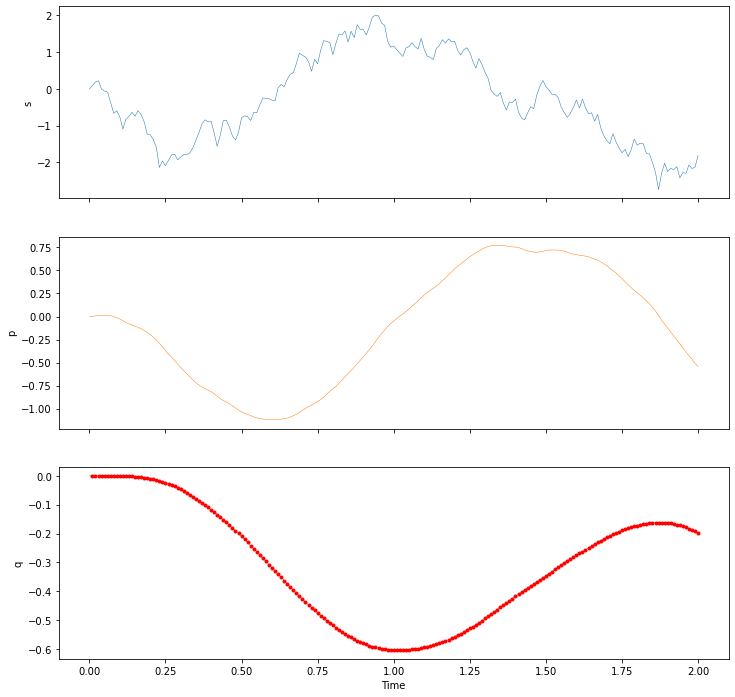

In [5]:
fig, axes = plt.subplots(dim_x, 1, sharex=True, figsize=(12, 12))
labels = 'spq' # s: extended variable (rough component), p: momentum, q: position
for i, ax in enumerate(axes):
    ax.plot(t_seq_simulation, x_seq_obs[:, i], color=f'C{i}', lw=0.5)
    ax.set_ylabel(labels[i])
axes[2].plot(t_seq_simulation[obs_time_indices_simulation], y_obs, 'r.')
axes[-1].set_xlabel('Time')

In [6]:
num_obs_per_subseq = 200  # Number of obs in each fully conditioned subsequence
system = mici_extensions.ConditionedDiffusionConstrainedSystem(
    dt_observation,
    int(dt_observation / dt_simulation),
    num_obs_per_subseq,
    y_obs,
    dim_u,
    dim_x,
    dim_n,
    symnum.numpify(dim_θ, dim_x, dim_n, (), numpy_module=jnp)(lambda θ, x, n, t: step_func(x, θ, n, t)),
    generate_x_0,
    generate_θ,
    obs_func,
    use_gaussian_splitting=False,
    dim_v_0=dim_v_0,
)


In [7]:
max_iters = 50  # Maximum number of quasi-Newton iterations in retraction solver
constraint_tol = 1e-9  # Convergence tolerance in constraint (observation) space
position_tol = 1e-8  # Convergence tolerance in position (latent) space
integrator = mici.integrators.ConstrainedLeapfrogIntegrator(
    system,
    projection_solver=mici_extensions.jitted_solve_projection_onto_manifold_newton,
    reverse_check_tol=2 * position_tol,
    projection_solver_kwargs=dict(
        constraint_tol=constraint_tol, position_tol=position_tol, max_iters=max_iters
    ),
)

In [8]:
rng = np.random.default_rng(20230331)
sampler = mici.samplers.MarkovChainMonteCarloMethod(
    rng,
    transitions={
        "momentum": mici.transitions.IndependentMomentumTransition(system),
        "integration": mici.transitions.MultinomialDynamicIntegrationTransition(
            system, integrator
        ),
        # "switch_partition": mici_extensions.SwitchPartitionTransition(system),
    },
)

In [9]:
def generate_x_obs_seq_init(rng):
    return jnp.concatenate((rng.standard_normal(y_obs.shape[:1] + (2,)), y_obs), -1)

In [10]:
num_chains = 2  # Number of independent Markov chains to run
init_states = [
    mici_extensions.find_initial_state_by_gradient_descent(
        system, rng, generate_x_obs_seq_init, reg_coeff=0.25,
    )
    for _ in range(num_chains)
]

INFO:root:Starting try 1
INFO:root:Iteration      0: mean|constr|^2 = 8.056e-01 max|constr| = 3.897e+00
INFO:root:Iteration    100: mean|constr|^2 = 1.021e-01 max|constr| = 9.429e-01
INFO:root:Iteration    200: mean|constr|^2 = 5.954e-02 max|constr| = 1.826e-01
INFO:root:Iteration    300: mean|constr|^2 = 5.832e-02 max|constr| = 1.438e-01
INFO:root:Within coarse_tol attempting projection.
INFO:root:Found constraint satisfying state.
INFO:root:Starting try 1
INFO:root:Iteration      0: mean|constr|^2 = 7.090e-01 max|constr| = 3.823e+00
INFO:root:Iteration    100: mean|constr|^2 = 2.924e-01 max|constr| = 3.824e+00
INFO:root:Iteration    200: mean|constr|^2 = 2.924e-01 max|constr| = 3.824e+00
INFO:root:Iteration    300: mean|constr|^2 = 2.924e-01 max|constr| = 3.824e+00
INFO:root:Iteration    400: mean|constr|^2 = 2.923e-01 max|constr| = 3.824e+00
INFO:root:Iteration    500: mean|constr|^2 = 2.923e-01 max|constr| = 3.824e+00
INFO:root:Iteration    600: mean|constr|^2 = 2.923e-01 max|const

In [11]:
for c, state in enumerate(init_states):
    print(f"Initial state {c+1}: neg_log_dens={system.neg_log_dens(state):.4g} θ={generate_θ(state.pos)}")

Initial state 1: neg_log_dens=124.7 θ=[9.77535414e+01 6.02950775e+01 1.95637638e-02]
Initial state 2: neg_log_dens=132.2 θ=[1.19330573e+02 7.31482970e+01 2.14192818e-02]


In [12]:
def trace_func(state):
    θ = generate_θ(state.pos[:dim_u])
    v_0 = state.pos[dim_u:dim_v_0 + dim_u]
    x_0 = generate_x_0(θ, v_0)
    n_seq = state.pos[dim_v_0 + dim_u:].reshape((-1, dim_n))
    x_seq = generate_x_seq(x_0, θ, n_seq, t_seq_simulation)
    return {"λ": θ[0], "α": θ[1], "β": θ[2], "x_seq": x_seq}

In [13]:
n_warm_up_iter = 1000  # Number of chain samples in warm-up sampling phase
n_main_iter = 1000  # Number of chain samples in main sampling phase
final_states, traces, stats = sampler.sample_chains_with_adaptive_warm_up(
    n_warm_up_iter,
    n_main_iter,
    init_states,
    trace_funcs=[trace_func],
    adapters={
        "integration": [
            mici.adapters.DualAveragingStepSizeAdapter(
                log_step_size_reg_coefficient=0.1
            )
        ]
    },
    monitor_stats=[
        ("integration", "accept_stat"),
        ("integration", "convergence_error"),
        ("integration", "non_reversible_step"),
        ("integration", "n_step"),
    ],
)

Sampling stage: Adaptive warm up [54:10] > Main non-adaptive [53:41]

Chain 1/2: 100%|██████████|1000/1000 [22:57<00:00, 1.38s/it, accept_stat=0.803, convergence_error=0.00, non_reversible_step=0.00, n_step=15.0]

INFO:mici.transitions:Terminating trajectory due to error:
Newton iteration diverged on iteration 3. Last |c|=nan, |δq|=nan.
INFO:mici.transitions:Terminating trajectory due to error:
Newton iteration diverged on iteration 2. Last |c|=nan, |δq|=nan.
INFO:mici.transitions:Terminating trajectory due to error:
Newton iteration diverged on iteration 3. Last |c|=nan, |δq|=nan.


Chain 2/2: 100%|██████████|1000/1000 [30:43<00:00, 1.84s/it, accept_stat=0.821, convergence_error=0.00, non_reversible_step=0.00, n_step=15.0]

INFO:mici.transitions:Terminating trajectory due to error:
Newton iteration diverged on iteration 2. Last |c|=nan, |δq|=nan.


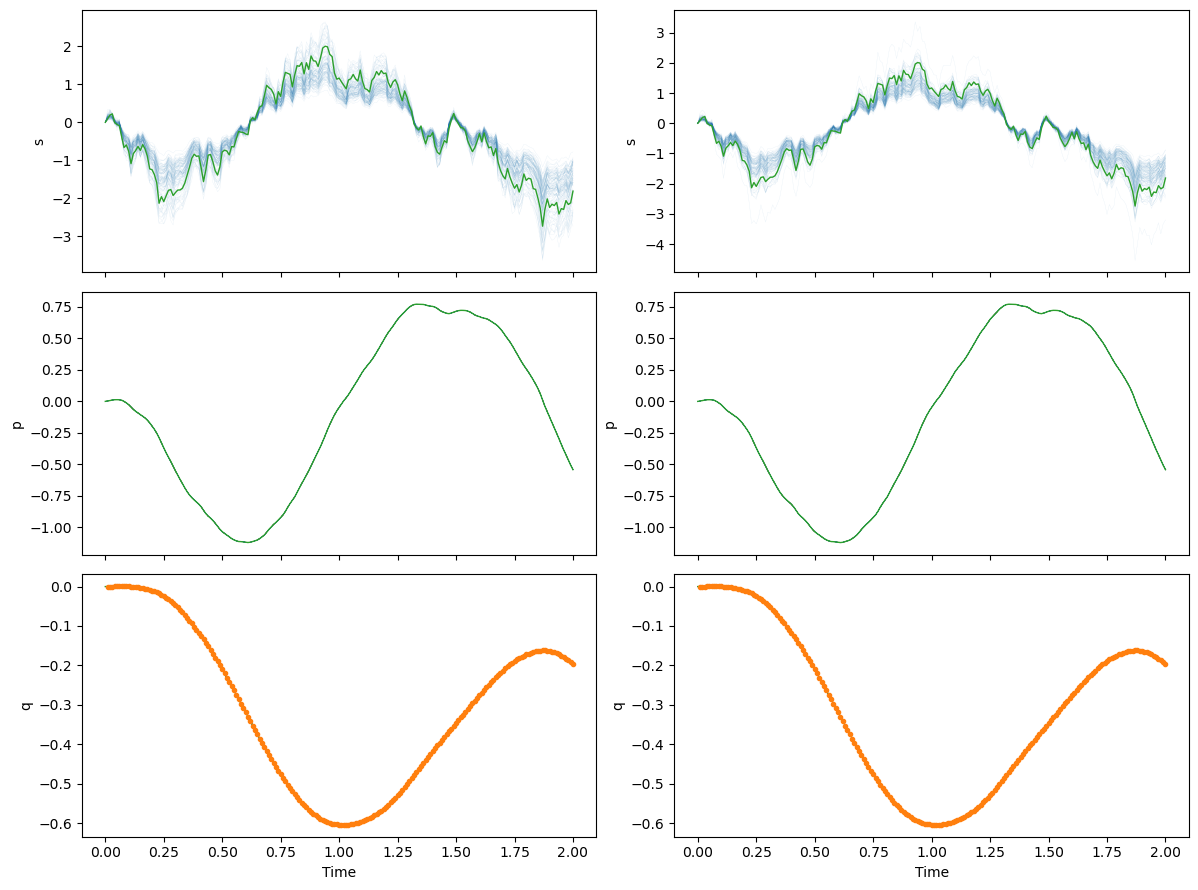

In [14]:
fig, axes = plt.subplots(dim_x, num_chains, sharex=True, figsize=(12, 9), dpi=100)
labels = 'spq' # s: extended variable (rough component), p: momentum, q: position
for c, axes_col in enumerate(axes.T):
    for i, ax in enumerate(axes_col):
        ax.plot(t_seq_simulation, traces["x_seq"][c][0::10, :, i].T, color="C0", lw=0.25, alpha=0.1)
        ax.plot(t_seq_simulation, x_seq_obs[:, i], color="C2", lw=1)
        ax.set_ylabel(labels[i])
    axes_col[2].plot(t_seq_simulation[obs_time_indices_simulation], y_obs, '.', color="C1")
    axes_col[-1].set_xlabel('Time')
fig.tight_layout()

In [15]:
arviz.summary(traces, var_names=["λ", "α", "β"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
λ,2.681,0.607,1.525,3.729,0.007,0.006,6602.0,1349.0,1.0
α,1.036,0.401,0.380,1.747,0.007,0.007,5026.0,1015.0,1.0
β,0.982,0.417,0.348,1.770,0.006,0.006,6281.0,1373.0,1.0


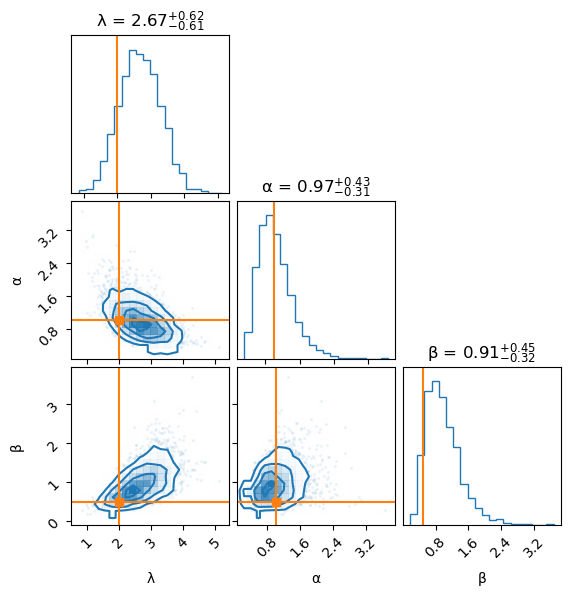

In [16]:
fig, axes = plt.subplots(dim_θ, dim_θ, figsize=(2 * dim_θ, 2 * dim_θ), dpi=100)
_ = corner.corner(
    traces,
    var_names=["λ", "α", "β"],
    truths=list(θ_obs),
    color="C0",
    truth_color="C1",
    show_titles=True,
    smooth=0.5,
    fig=fig
)